# Smart Factory Energy Consumption Prediction
This notebook performs preprocessing and builds a machine learning model to predict equipment energy consumption.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load dataset
df = pd.read_csv('/Users/arsalankhan/Desktop/DS-Intern-Assignment-Arsalan/data/data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month
df.drop('timestamp', axis=1, inplace=True)
df.head()

,equipment_energy_consumption,lighting_energy,zone1_temperature,zone1_humidity,zone2_temperature,zone2_humidity,zone3_temperature,zone3_humidity,zone4_temperature,zone4_humidity,...,atmospheric_pressure,outdoor_humidity,wind_speed,visibility_index,dew_point,random_variable1,random_variable2,hour,dayofweek,month
0,60.0,-77.78778596503064,33.74660933896648,47.59666666666671,19.2,44.790000,19.79,NaN,19.000000,45.566667,...,733.5,92.0,7.000000,63.000000,5.300000,13.275433,13.275433,17,0,1
1,60.0,30.0,19.89,46.69333333333329,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,733.6,92.0,6.666667,59.166667,5.200000,18.606195,18.606195,17,0,1
2,50.0,30.0,19.89,46.3,19.2,44.626667,19.79,44.933333,35.921144,45.890000,...,733.7,92.0,6.333333,55.333333,5.100000,28.642668,28.642668,17,0,1
3,50.0,40.0,33.74660933896648,46.0666666666667,19.2,44.590000,19.79,45.000000,NaN,45.723333,...,733.8,92.0,6.000000,51.500000,37.673716,45.410389,45.410389,17,0,1
4,60.0,40.0,19.89,46.33333333333329,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,733.9,92.0,5.666667,47.666667,4.900000,10.084097,10.084097,17,0,1


In [ ]:
# Convert object columns to numeric
object_cols = df.select_dtypes(include=['object']).columns
df[object_cols] = df[object_cols].apply(pd.to_numeric, errors='coerce')
# Handle missing values
df = df.fillna(df.median(numeric_only=True))

In [7]:
df

,equipment_energy_consumption,lighting_energy,zone1_temperature,zone1_humidity,zone2_temperature,zone2_humidity,zone3_temperature,zone3_humidity,zone4_temperature,zone4_humidity,...,atmospheric_pressure,outdoor_humidity,wind_speed,visibility_index,dew_point,random_variable1,random_variable2,hour,dayofweek,month
0,60.000000,-77.787786,33.746609,47.596667,19.200000,44.790000,19.79,38.400000,19.000000,45.566667,...,733.500000,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433,17,0,1
1,60.000000,30.000000,19.890000,46.693333,19.200000,44.722500,19.79,44.790000,19.000000,45.992500,...,733.600000,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195,17,0,1
2,50.000000,30.000000,19.890000,46.300000,19.200000,44.626667,19.79,44.933333,35.921144,45.890000,...,733.700000,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668,17,0,1
3,50.000000,40.000000,33.746609,46.066667,19.200000,44.590000,19.79,45.000000,20.290000,45.723333,...,733.800000,92.000000,6.000000,51.500000,37.673716,45.410389,45.410389,17,0,1
4,60.000000,40.000000,19.890000,46.333333,19.200000,44.530000,19.79,45.000000,18.890000,45.530000,...,733.900000,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097,17,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16852,1139.985693,20.000000,22.100000,38.723333,19.790000,39.566667,21.29,38.845000,21.390000,35.863333,...,761.466667,68.333333,2.000000,64.666667,0.366667,10.707282,10.707282,20,0,10
16853,50.000000,86.002966,21.290000,39.626667,18.100000,44.290000,22.39,38.760000,20.290000,37.900000,...,752.250000,96.666667,1.000000,18.000000,3.150000,49.199695,49.199695,6,1,10
16854,50.000000,0.000000,21.390000,37.590000,18.463333,39.966667,21.10,37.790000,20.600000,33.790000,...,763.000000,84.166667,1.000000,60.833333,-0.633333,6.905370,6.905370,0,3,11
16855,80.000000,0.000000,22.500000,39.360000,23.600000,35.730000,23.10,38.000000,22.290000,38.000000,...,750.166667,50.333333,6.000000,40.000000,6.266667,25.020775,25.020775,13,4,11


In [8]:
# Feature and target separation
X = df.drop('equipment_energy_consumption', axis=1)
y = df['equipment_energy_consumption']

In [9]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()

In [10]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [12]:
# Create a modeling pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Hyperparameter tuning
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20, None]
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [14]:
# Evaluate model
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R^2 Score: {r2:.4f}")

MAE: 69.93
RMSE: 30556.36
R^2 Score: 0.0531


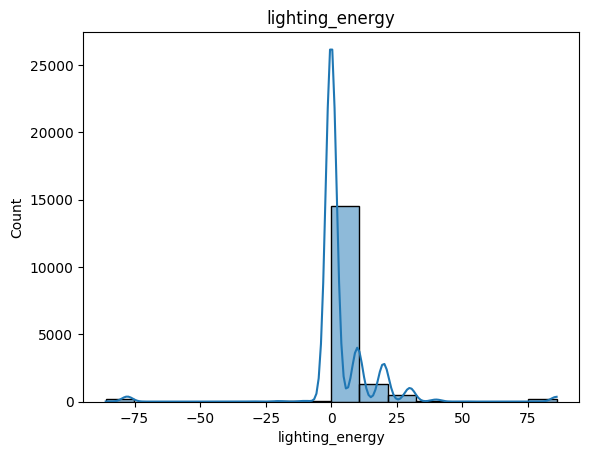

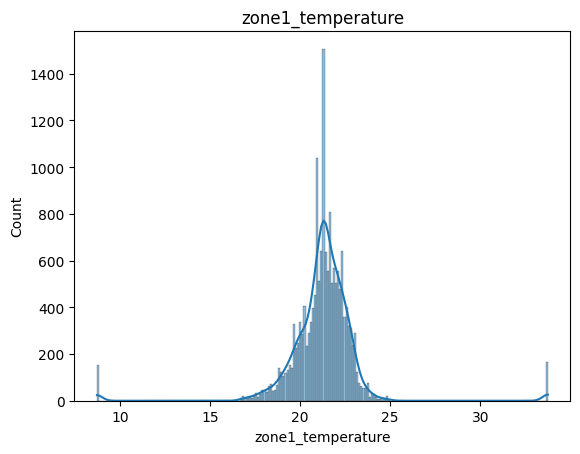

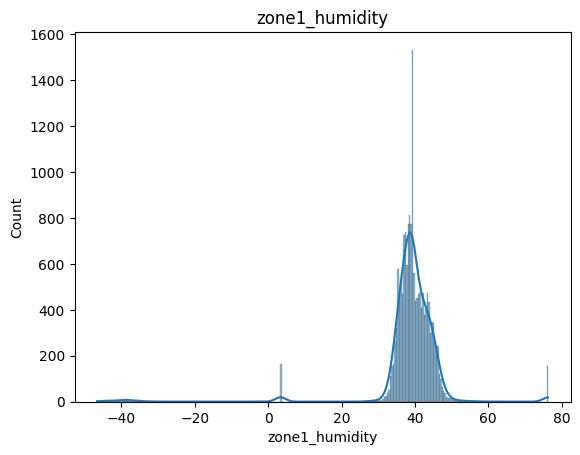

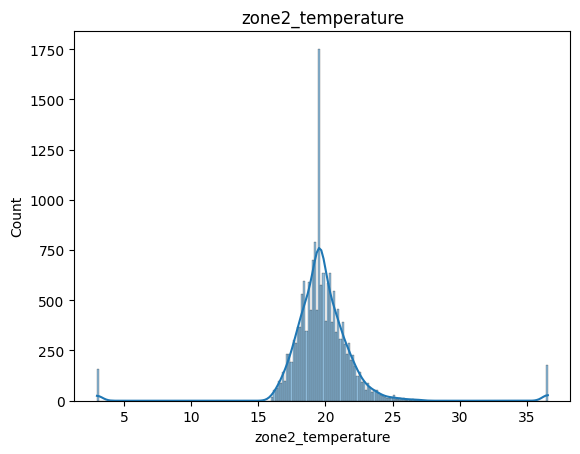

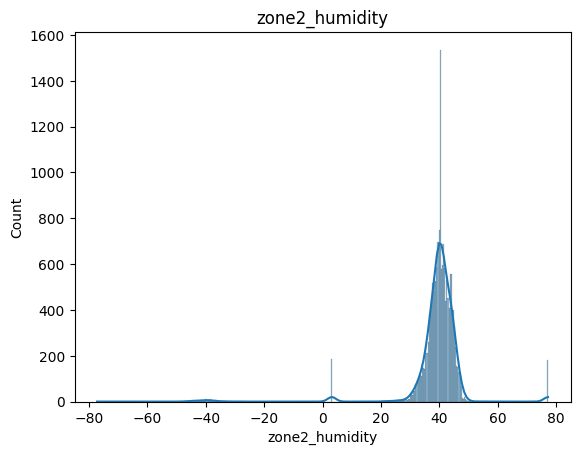

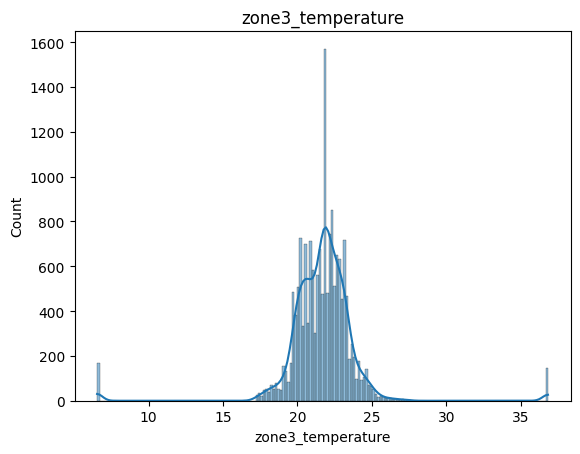

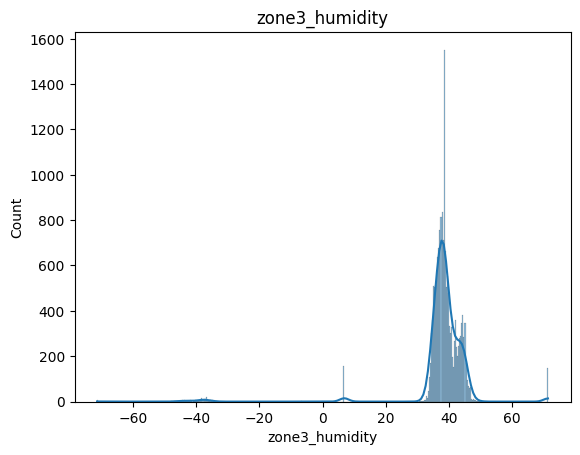

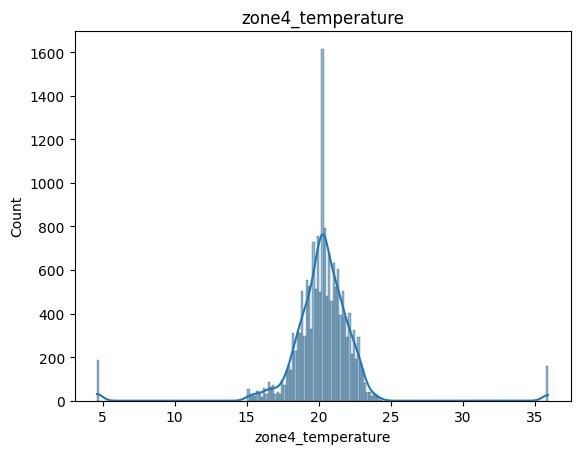

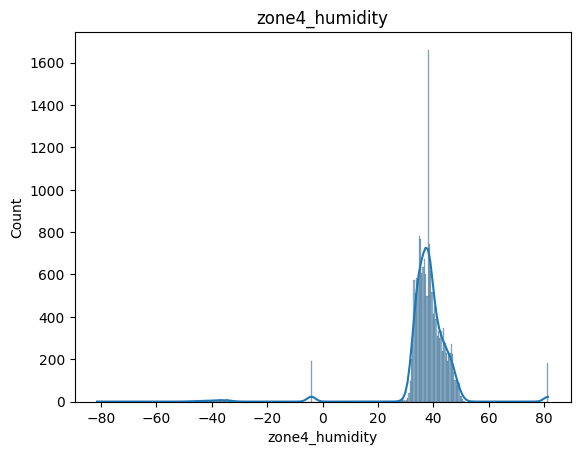

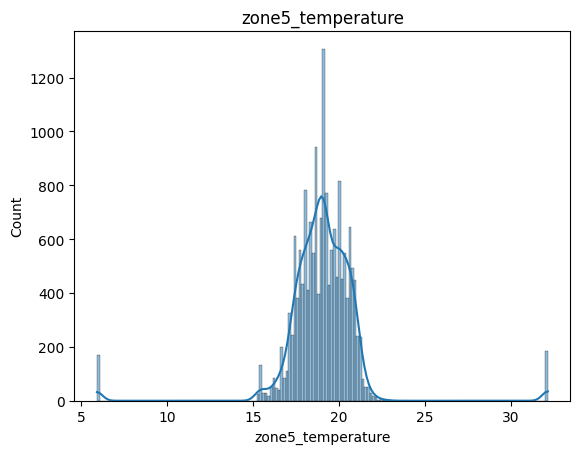

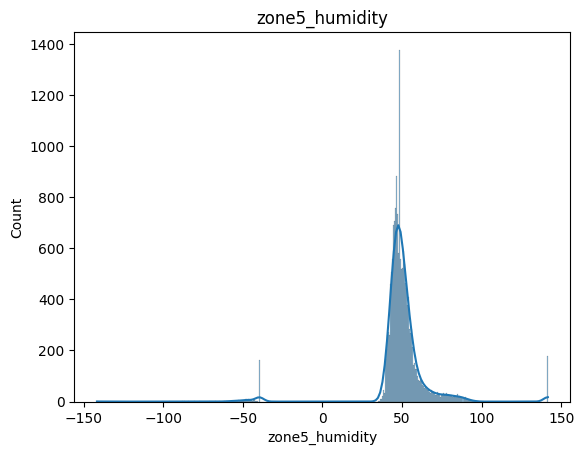

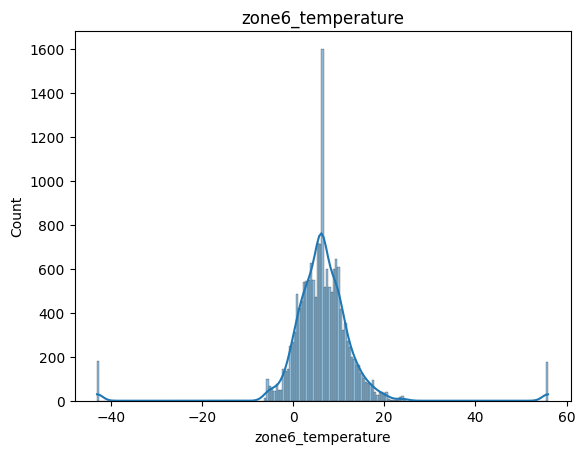

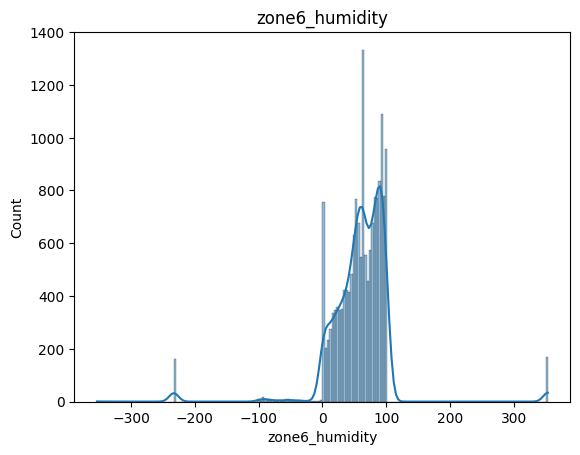

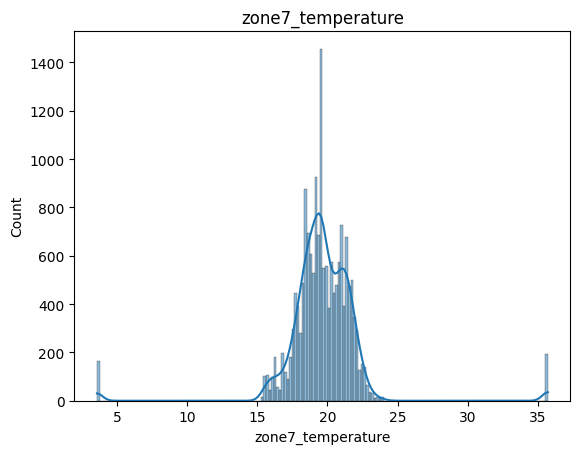

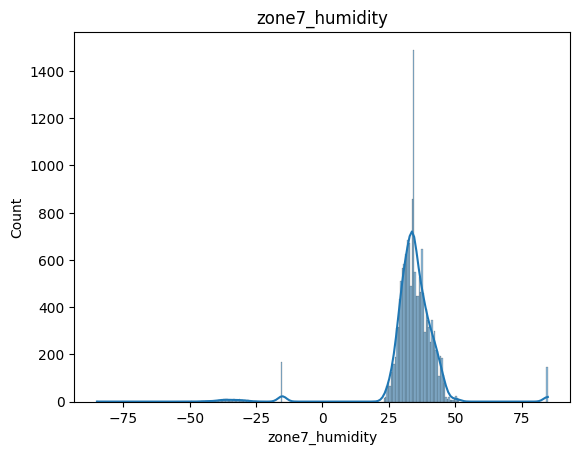

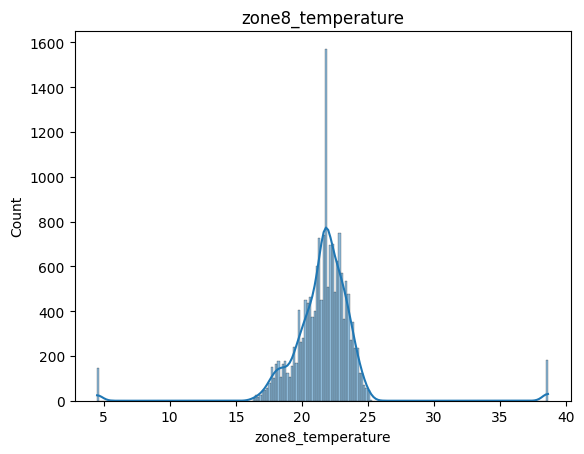

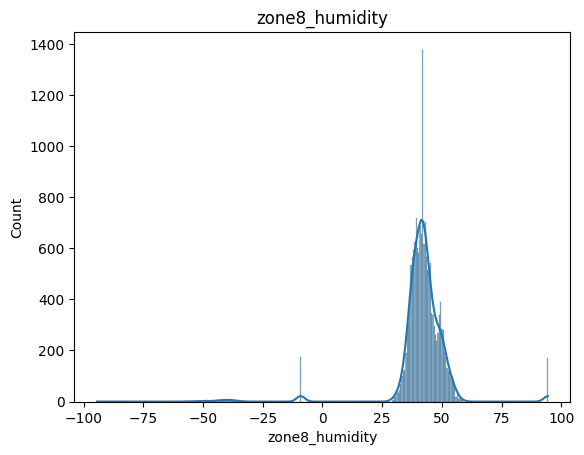

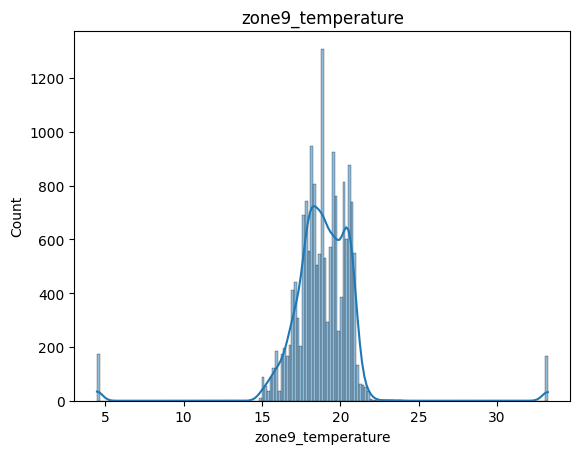

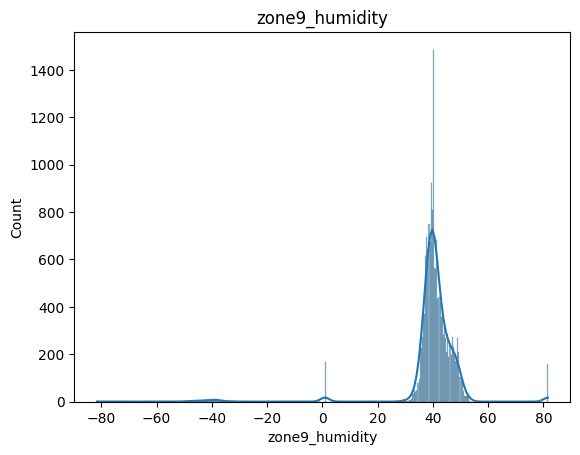

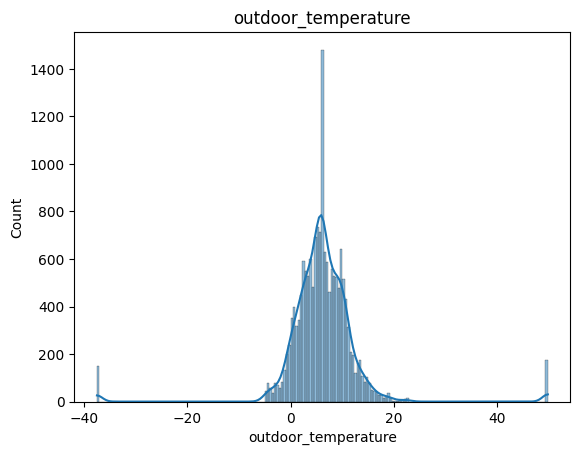

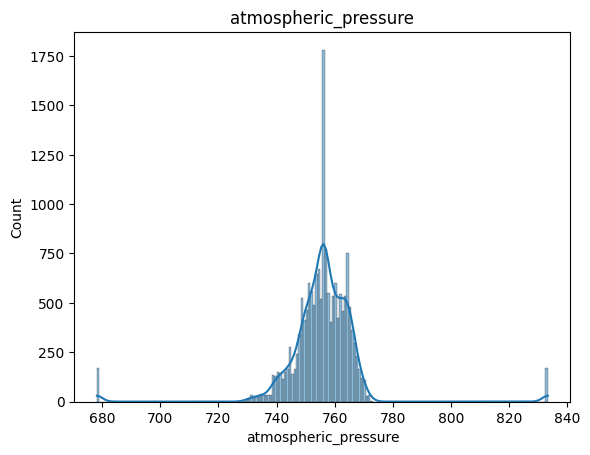

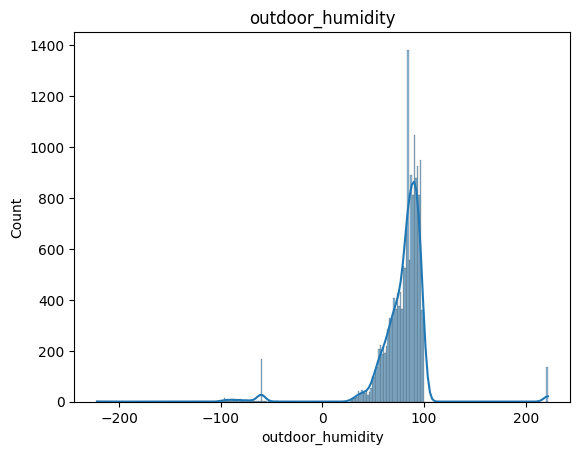

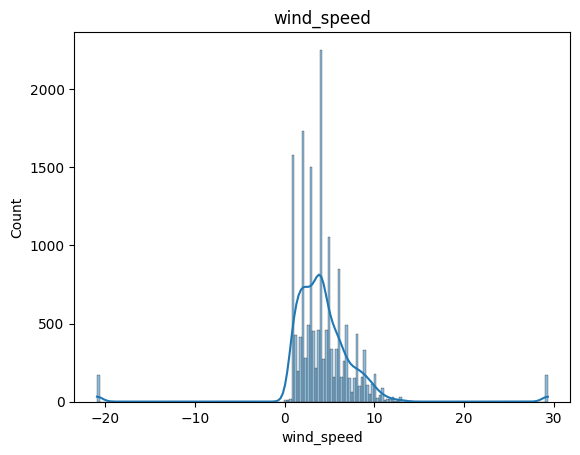

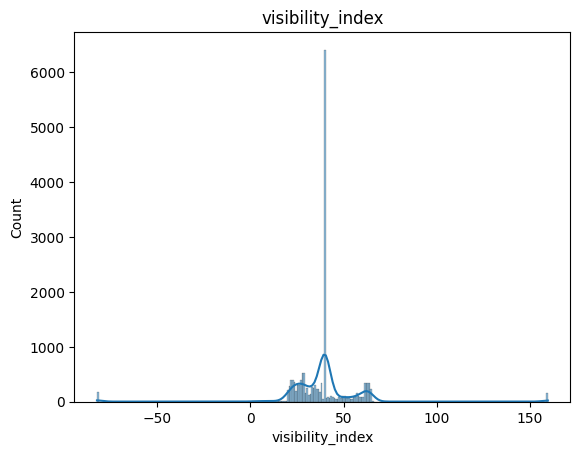

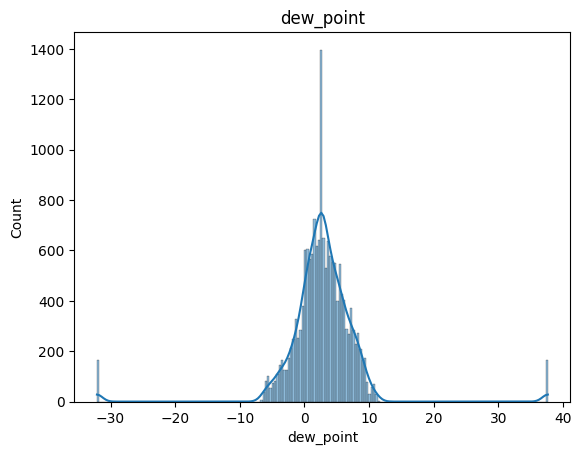

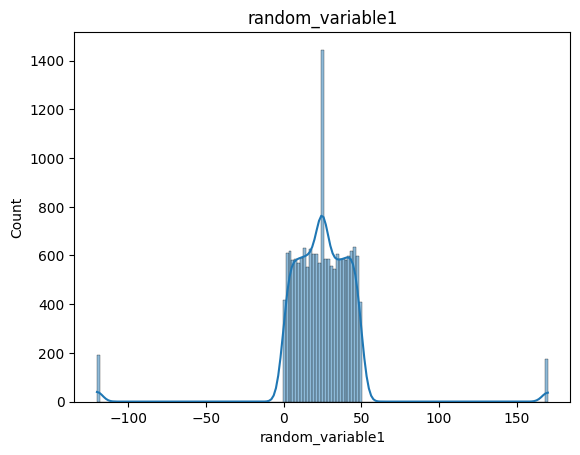

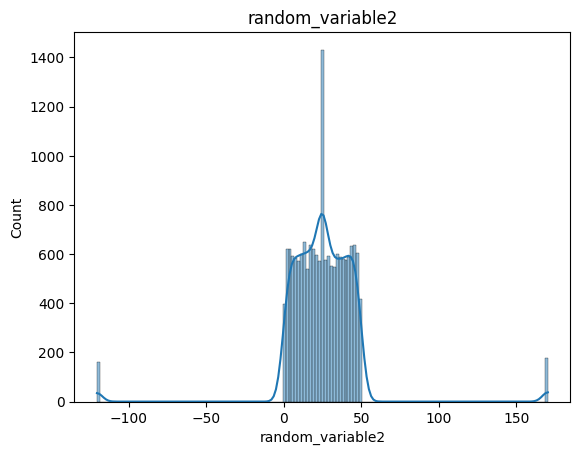

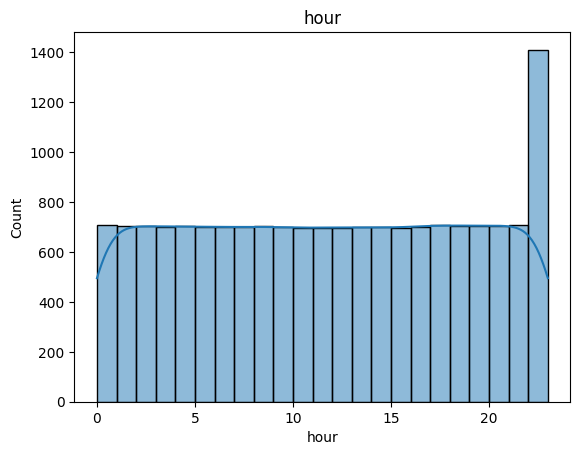

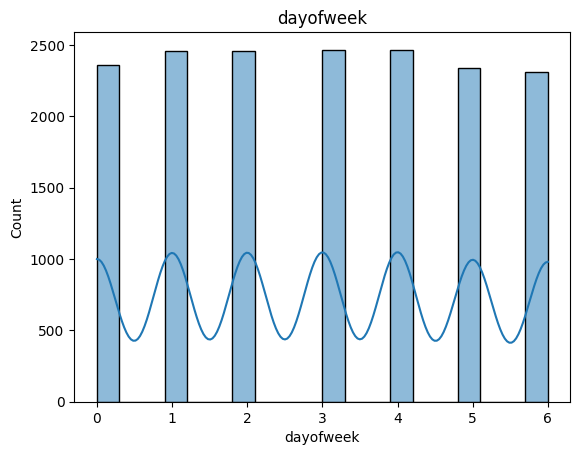

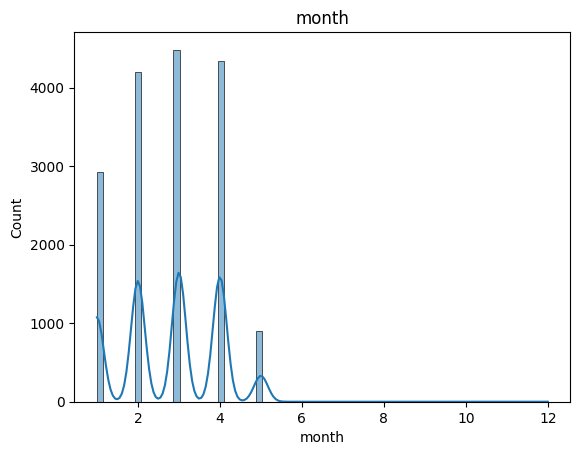

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in numerical_cols:
    sns.histplot(df[col], kde=True)
    plt.title(col)
    plt.show()